In [2]:
!pip install torch torchvision
!pip install pyro-ppl
!pip install Arviz

import torch
import pyro
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pyro.distributions as dist



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.2 MB/s eta 0:00:00


In [3]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 2, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 2, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 2)


def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")

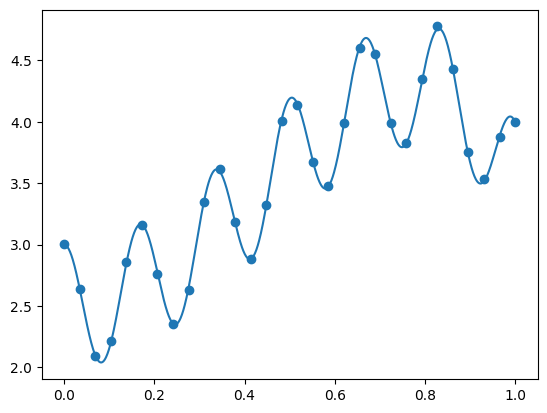

In [411]:
N = 30
# generate 30 datapoints (20/10 train/test)
X = torch.linspace(0, 1, N)
y = 6 * X ** 2 - 5 * X ** 4 + 1.5 - (torch.sin(6 * torch.pi * X)) ** 2 + 3/2 + dist.Normal(0.0, 0.01).sample(sample_shape=(N,))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test

xx = torch.linspace(0, 1, 1000)
yy = 6 * xx ** 2 - 5 * xx ** 4 + 1.5 - (torch.sin(6 * torch.pi * xx)) ** 2 + 3/2

# scatter plot of data with true function
plt.scatter(X,y)
plt.plot(xx,yy)
plt.show()

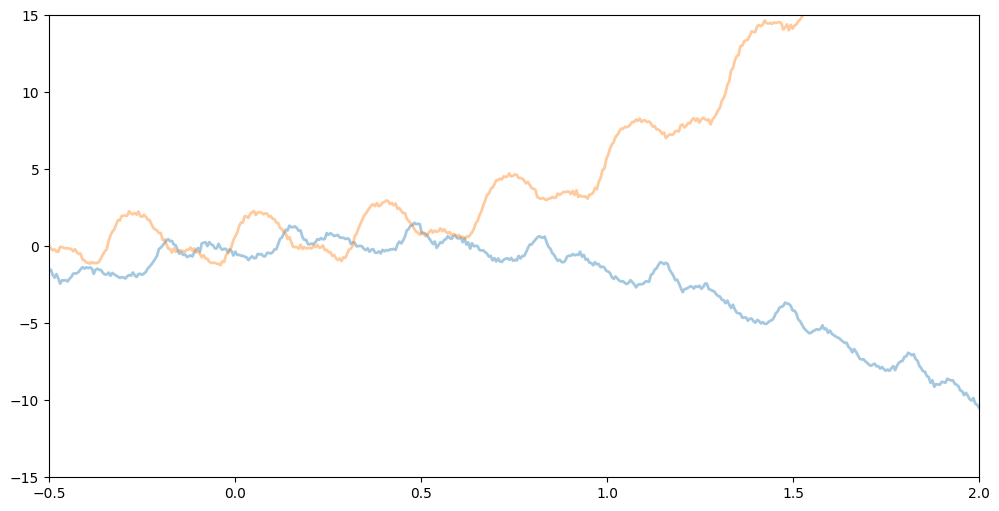

In [416]:
# define the model
pyro.clear_param_store()

periodic = gp.kernels.Periodic(
    input_dim=1, period=torch.tensor(1/3) # 1/3 is the period of our sine function
)
polynomial = gp.kernels.Polynomial(
    input_dim=1, degree = 4
)


k = gp.kernels.Sum(periodic, polynomial)
model = gp.models.GPRegression(
    X=X_train,
    y=y_train,
    noise = torch.tensor(0.01),
    kernel=k
)
model
#model.kernel.kern1.lengthscale = torch.tensor(1.)
#model.kernel.kern1.lengthscale = torch.tensor(1.)
#model.kernel.kern1.lengthscale = torch.tensor(1.)
plot(model=model, kernel=k, n_prior_samples=2)
_ = plt.ylim((-15, 15))

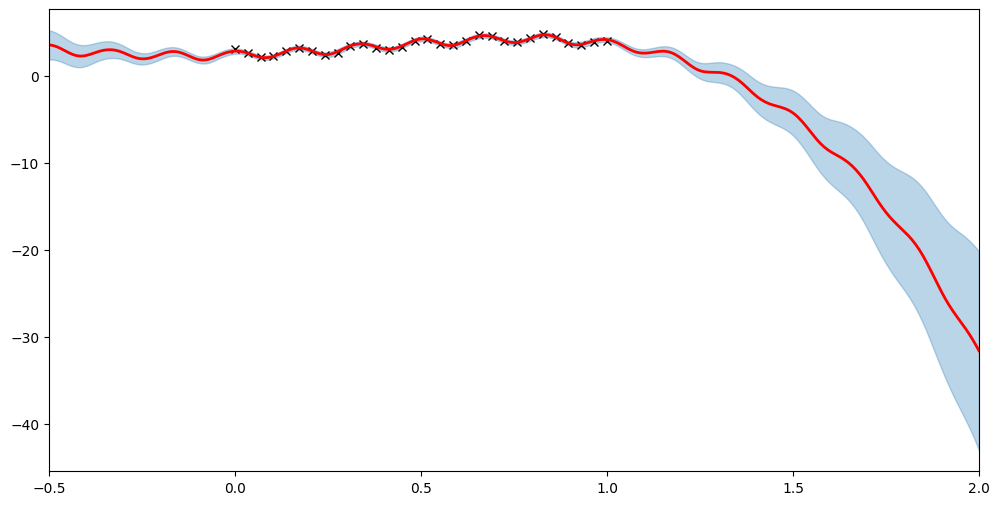

In [417]:
plot(model=model, plot_observed_data=True, plot_predictions=True)

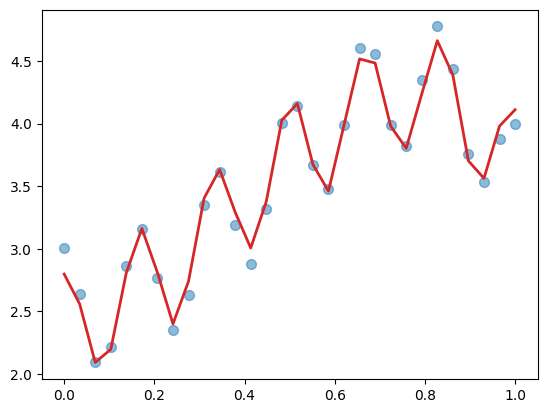

In [418]:
plt.scatter(X, y, s=50, alpha=0.5)

with torch.no_grad():
    mean, var = model(X)
_ = plt.plot(X, mean, color="C3", lw=2)

In [ ]:
from operator import length_hint
# grid search:
from sklearn.metrics import mean_squared_error

# Define the grid
k0_lengthscale_grid = [0.1, 0.5, 1.0, 2.5, 5.0]
k0_variance_grid = [0.1, 0.5, 1.0, 2.5, 5.0]
k1_lengthscale_grid = [0.1, 0.5, 1.0, 2.5, 5.0]
k1_variance_grid = [0.1, 0.5, 1.0, 2.5, 5.0]

# Grid search
best_ll = float('-inf')
best_params = None
best_model = None

for ls0 in k0_lengthscale_grid:
    for var0 in k0_variance_grid:
        for ls1 in k1_lengthscale_grid:
            for var1 in k1_variance_grid:
                #print(ls0, var0, ls1, var1)
                pyro.clear_param_store()

                # Define the GP model
                # Define kernels with initial values
                polynomial = gp.kernels.Polynomial(input_dim=1, degree=3, bias = torch.tensor(ls0), variance = torch.tensor(var0))
                periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.33), lengthscale=torch.tensor(ls1), variance=torch.tensor(var1))
                rbf = gp.kernels.RBF(input_dim=1, lengthscale=torch.tensor(ls0), variance=torch.tensor(var0))
                # Combine kernels
                #k = gp.kernels.Sum(polynomial, periodic)
                k = gp.kernels.Sum(periodic, rbf)
                # GP Regression model
                model = gp.models.GPRegression(X_train, y_train, k, noise=torch.tensor(0.01), jitter=0.001)

                # Assign priors to lengthscales and variances of the kernels
                # LogNormal priors since positive, unrestrictive
                #model.kernel.kern0.bias = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(ls0)))
                #model.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(var0)))
                #model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(ls1)))
                #model.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(var1)))

                # Train the model (you can replace this with your own training routine)
                #optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                #loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
                #num_steps = 1000
                #for step in range(num_steps):
                #    optimizer.zero_grad()
                #    loss = loss_fn(model.model, model.guide)
                #    loss.backward()
                #    optimizer.step()


                # evaluate using the posterior prediction
                model.eval()
                with torch.no_grad():
                    # Get predictive mean and variance
                    predictive_mean, predictive_var = model(X_test)

                    # Calculate the log likelihood using the GP's predictive distribution
                    predictive_normal = dist.Normal(predictive_mean, predictive_var.sqrt())
                    log_likelihood = predictive_normal.log_prob(y_test).sum()


                # Update the best model
                if log_likelihood > best_ll:
                    best_ll = log_likelihood
                    best_params = (ls0, var0, ls1, var1)
                    best_model = model

print(f'Best log-likelihood: {best_ll}')
print(f'Best Hyperparameters: Bias0: {best_params[0]}, Variance0: {best_params[1]}, Lengthscale1: {best_params[2]}, Variance1: {best_params[3]}')


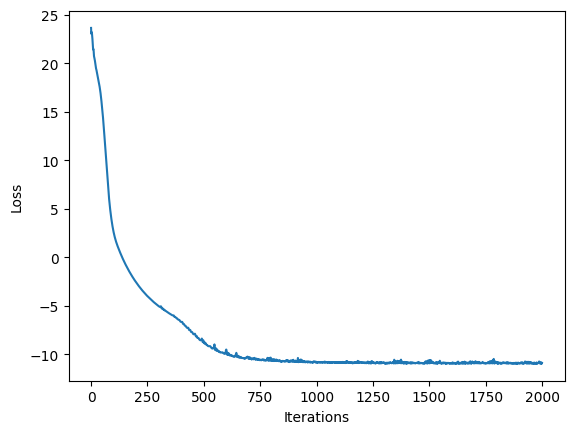

In [412]:
#best_baseline model

#Best log-likelihood: -1.6939897537231445
#Best Hyperparameters: Bias0: 0.5, Variance0: 2.0, Lengthscale1: 0.5, Variance1: 0.5

bias_polynomial, variance_polynomial = 1.5, 6.0
lengthscale_periodic, variance_periodic = 0.33, 1.5


# Clear Pyro parameter store
pyro.clear_param_store()

# Define kernels with initial values
polynomial = gp.kernels.RBF(input_dim=1,
                                   lengthscale = torch.tensor(bias_polynomial),
                                   variance = torch.tensor(variance_polynomial))
periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.33),
                               lengthscale = torch.tensor(lengthscale_periodic),
                               variance = torch.tensor(variance_periodic))

# Combine kernels
k = gp.kernels.Sum(polynomial, periodic)

# GP Regression model
baseline = gp.models.GPRegression(X_train, y_train, k, noise=torch.tensor(0.01))

optimizer = torch.optim.Adam(baseline.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(baseline.model, baseline.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

In [413]:
# posterior predictive log-likelihood of the test set

def calc_log_likelihood_test(model, X_test, y_test):
  model.eval()
  with torch.no_grad():
    predictive_mu, predictive_sigma = model(X_test)

  normal = dist.Normal(predictive_mu, predictive_sigma.sqrt())
  log_likelihood = normal.log_prob(y_test).sum().item()

  return log_likelihood

calc_log_likelihood_test(baseline, X_test, y_test)

#higher (less negative) log likelihood values indicate a better model fit.

24.486318588256836

In [8]:
from pyro.infer import MCMC, NUTS
# Use NUTS sampler now:
pyro.clear_param_store()

# model
def model(X, Y):
  # set uninformative log-normal priors on our kernel hyperparameters
  bias0 = pyro.sample("bias_polynomial", dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))
  variance0 = pyro.sample("variance_polynomial", dist.LogNormal(torch.log(torch.tensor(6.0)), torch.tensor((0.1))))
  lengthscale1 = pyro.sample("lengthscale_periodic", dist.LogNormal(torch.log(torch.tensor(1.0/(6*torch.pi))), torch.tensor((0.1))))
  variance1 = pyro.sample("variance_periodic", dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))


  # compute kernel
  polynomial = gp.kernels.Polynomial(input_dim=1, degree=3, bias=bias0, variance=variance0)
  periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.0/3), lengthscale=lengthscale1, variance=variance1)
  k = gp.kernels.Sum(polynomial, periodic)

  # define GP model
  gpmodel = gp.models.GPRegression(X, Y, k, noise=torch.tensor(0.01))
  gpmodel
  # Sample from the GP model's likelihood
  mu, sigma = gpmodel(X)
  #print("Shape of mu:", mu.shape)
  #print("Shape of sigma:", sigma.shape)
  pyro.sample("obs", dist.Normal(mu, sigma.sqrt()), obs=Y)

  # need to explicitly include the Log likelihood (here we are assuming Gaussian noise)
  #log_likelihood = dist.Normal(mu, sigma.sqrt()).log_prob(Y).sum().unsqueeze(0).detach()
  #pyro.deterministic("log_likelihood", log_likelihood)

# Run NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=200, num_chains = 4)
mcmc.run(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 700/700 [00:48, 14.42it/s, step size=9.41e-01, acc. prob=0.885]


In [112]:
# Extract samples
posterior_samples = mcmc.get_samples()

In [113]:
# Print summary statistics
mcmc.summary(prob=0.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
       bias_polynomial      1.51      0.15      1.50      1.23      1.81   2211.14      1.00
  lengthscale_periodic      0.05      0.01      0.05      0.04      0.06   2446.20      1.00
     variance_periodic      1.50      0.15      1.50      1.23      1.81   2015.10      1.00
   variance_polynomial      6.03      0.61      5.99      4.78      7.18   2304.83      1.00

Number of divergences: 0


In [114]:
def compute_posterior_likelihood_mc(X_train, y_train, X_test, y_test, samples, num_samples):
    likelihoods = []

    for i in range(num_samples):
        # Extract the hyperparameters for this sample
        params = {
            "bias_polynomial": samples['bias_polynomial'][i],
            "lengthscale_periodic": samples['lengthscale_periodic'][i],
            "variance_periodic": samples['variance_periodic'][i],
            "variance_polynomial": samples['variance_polynomial'][i],
        }

        # Construct the kernel with the current set of hyperparameters
        polynomial = gp.kernels.Polynomial(input_dim=1, degree=3, bias=params['bias_polynomial'], variance=params['variance_polynomial'])
        periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.0/3), lengthscale=params['lengthscale_periodic'], variance=params['variance_periodic'])
        kernel = gp.kernels.Sum(polynomial, periodic)

        # Construct the GP model (you might need to adapt this to fit your specific GP model structure)
        gp_model = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

        # Generate predictions for the test data
        mean, variance = gp_model(X_test, full_cov=False, noiseless=False)

        # Gaussian likelihood for the test data
        likelihood = dist.Normal(mean, variance.sqrt()).log_prob(y_test).exp()
        likelihoods.append(likelihood)

    # Average the likelihoods and then take the log
    avg_likelihood = torch.mean(torch.stack(likelihoods))
    avg_log_likelihood = torch.log(avg_likelihood).item()

    return avg_log_likelihood


compute_posterior_likelihood_mc(X_train, y_train, X_test, y_test, posterior_samples, 500)

-0.5730844736099243

In [115]:
import arviz as az

inference_data = az.from_pyro(mcmc)
az.summary(inference_data)

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias_polynomial,1.508,0.151,1.224,1.787,0.003,0.002,2258.0,1351.0,1.0
lengthscale_periodic,0.053,0.005,0.044,0.062,0.000,0.000,2492.0,1490.0,1.0
variance_periodic,1.504,0.150,1.249,1.809,0.003,0.002,2017.0,1590.0,1.0
variance_polynomial,6.033,0.606,4.858,7.157,0.013,0.009,2335.0,1546.0,1.0


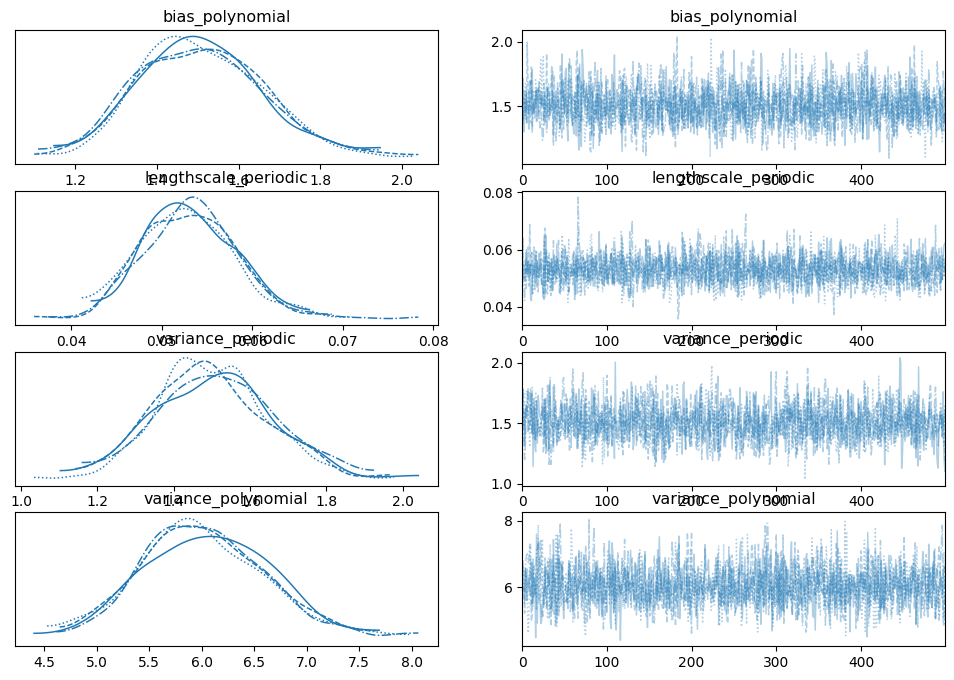

In [116]:
# Trace plot
az.plot_trace(inference_data)
plt.show()

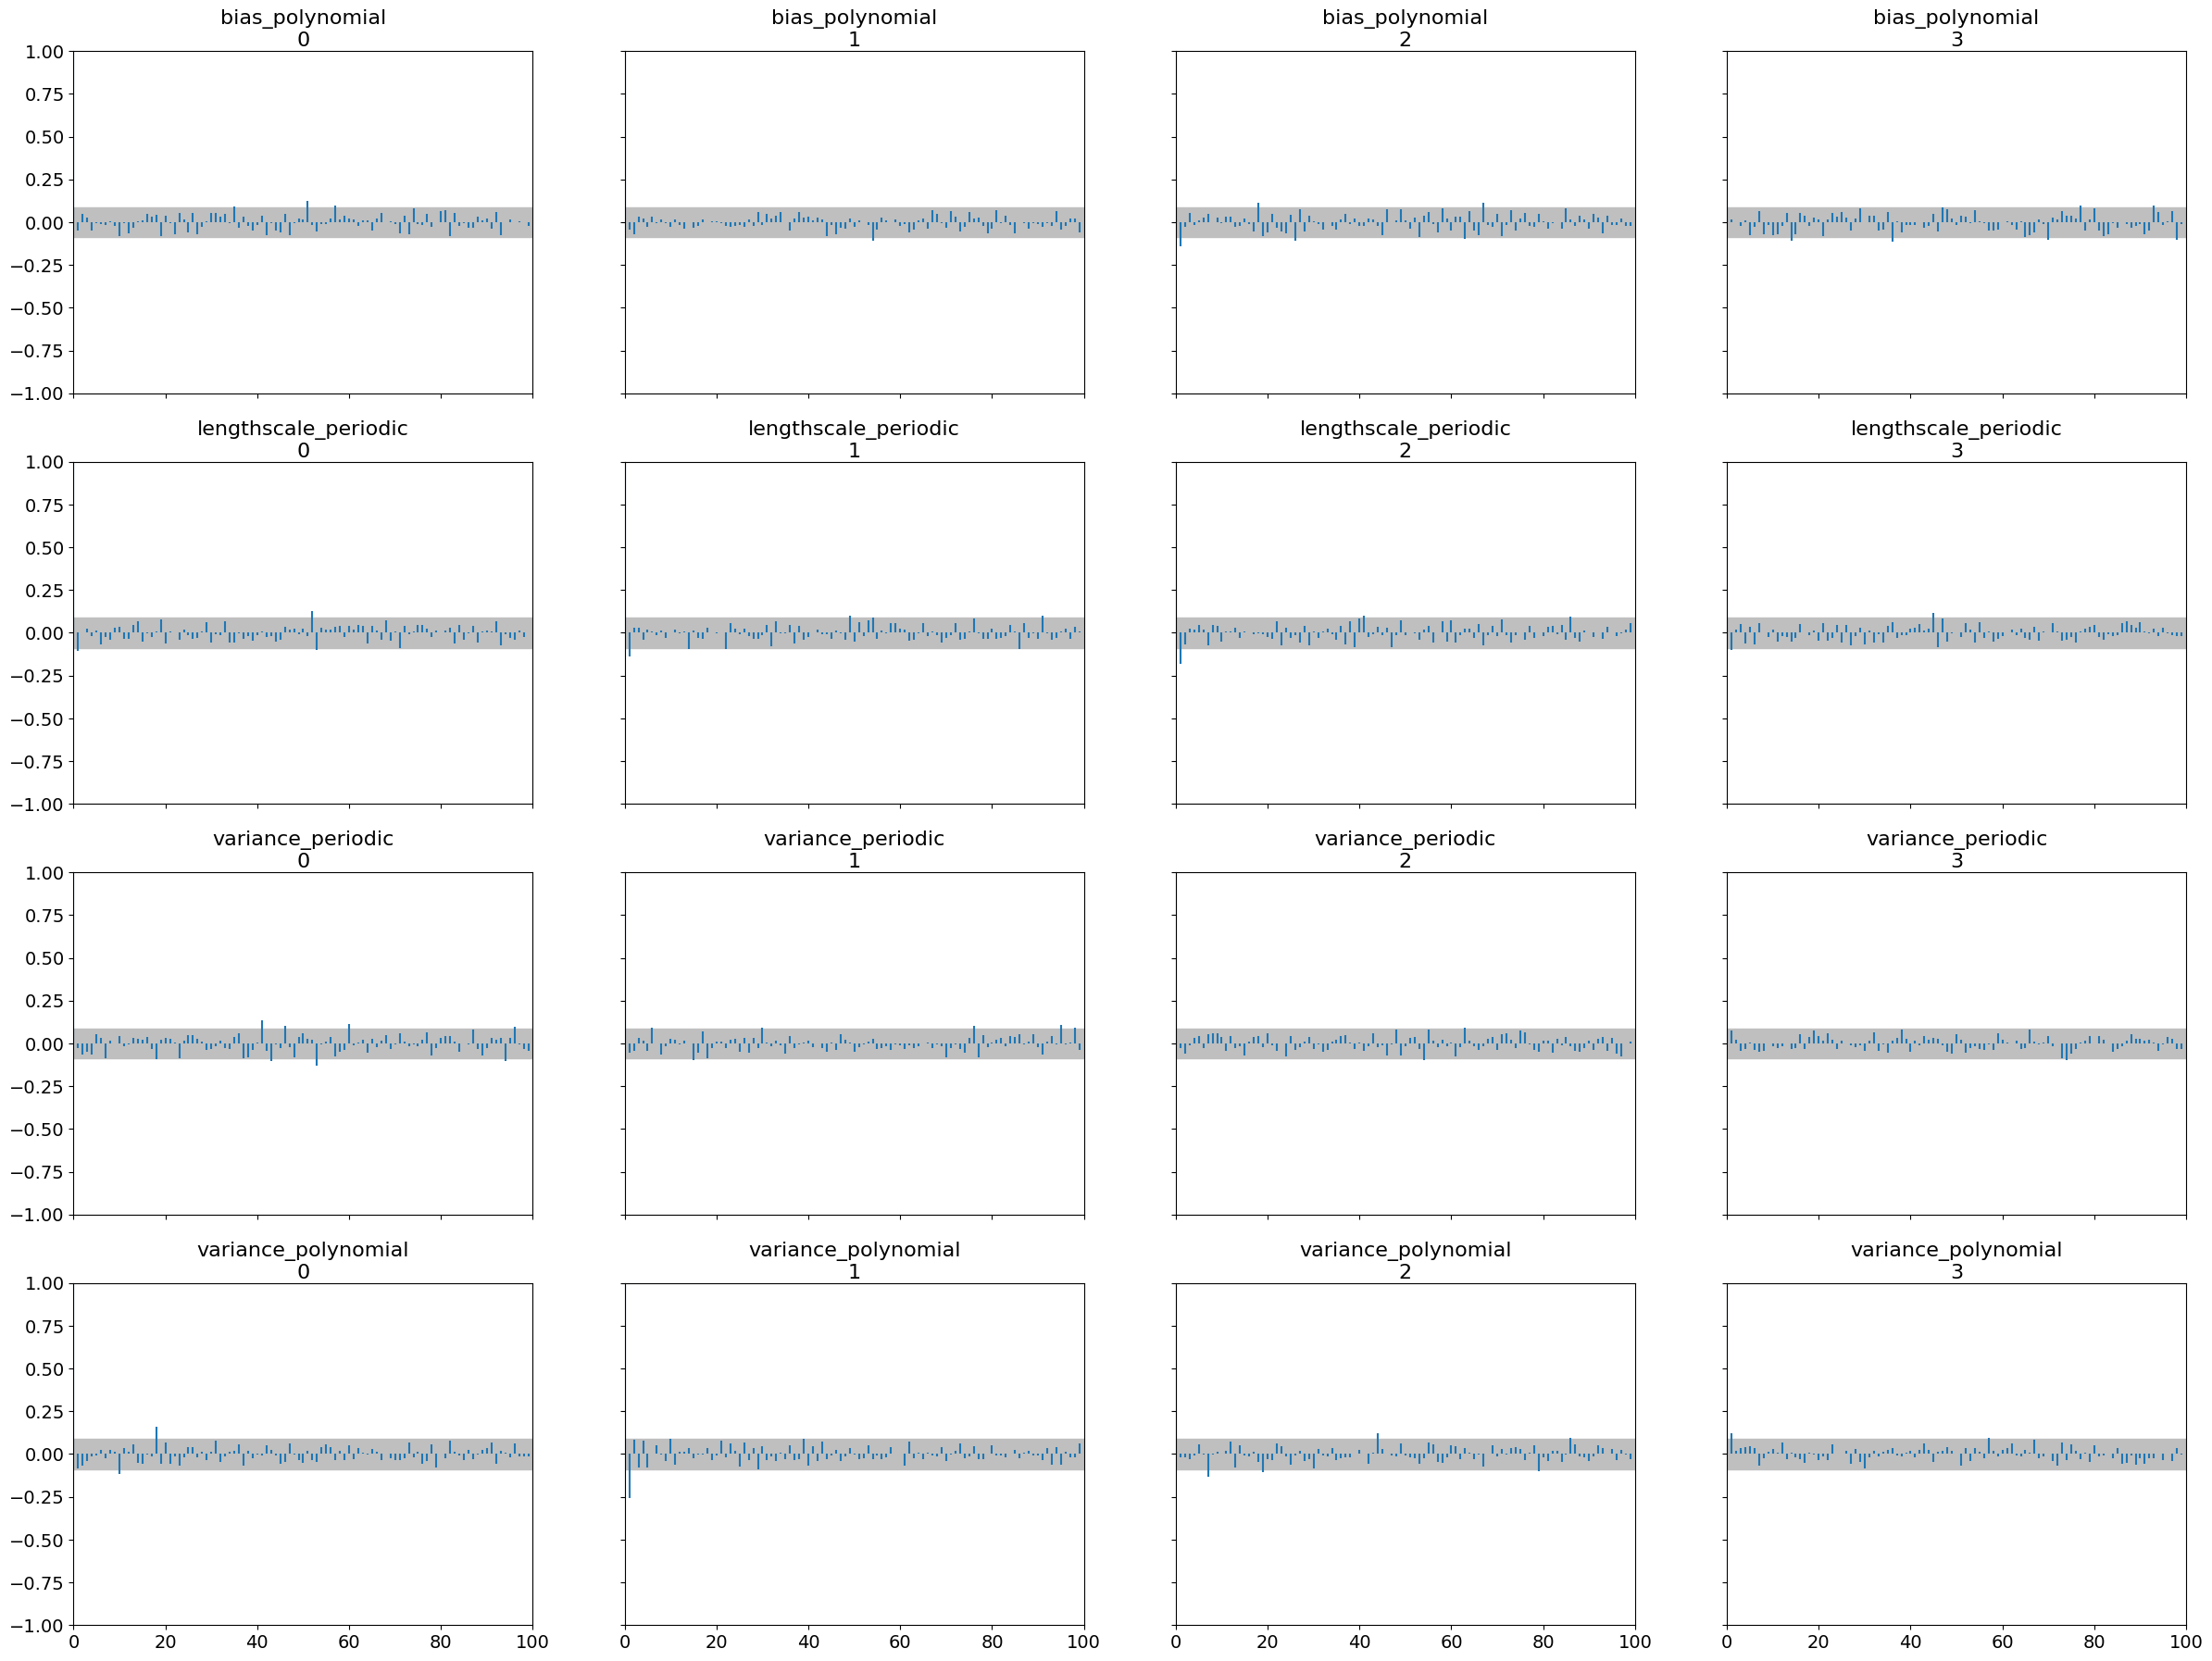

In [117]:
# Autocorrelation plot
az.plot_autocorr(inference_data)
plt.show()

In [ ]:
inference_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [427]:
def gen_data(n_size):

  X = torch.linspace(0, 1, n_size)
  y = 6 * X ** 2 - 5 * X ** 4 + 1.5 - (torch.sin(6 * torch.pi * X)) ** 2 + 3/2 + dist.Normal(0.0, 0.01).sample(sample_shape=(n_size,))

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

  return X_train, X_test, y_train, y_test

def run_model(model_type: str, X_train, y_train, num_steps = 1000, num_samples = 500, num_warmup = 200, num_chains = 4):
  # Train MAP model
  if model_type == "map":
    # Clear Pyro parameter store
    pyro.clear_param_store()

    # from the grid search
    bias_polynomial, variance_polynomial = 1.5, 6.0
    lengthscale_periodic, variance_periodic = 0.33, 1.5


    #polynomial = gp.kernels.Polynomial(input_dim=1, degree=3)
    #periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.33))

    # Define kernels with initial values
    polynomial = gp.kernels.Polynomial(input_dim=1, degree = 3,
                                      bias = torch.tensor(bias_polynomial),
                                      variance = torch.tensor(variance_polynomial))
    periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1/3),
                                  lengthscale = torch.tensor(lengthscale_periodic),
                                  variance = torch.tensor(variance_periodic))

    # Combine kernels
    k = gp.kernels.Sum(polynomial, periodic)

    # GP Regression model
    baseline = gp.models.GPRegression(X_train, y_train, k, noise=torch.tensor(0.01))


    #baseline.kernel.kern0.bias = pyro.nn.PyroSample(dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))
    #baseline.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(torch.log(torch.tensor(6.0)), torch.tensor((0.1))))
    #baseline.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.log(torch.tensor(1.0/(3))), torch.tensor((0.1))))
    #baseline.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))

    optimizer = torch.optim.Adam(baseline.parameters(), lr=0.01)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = num_steps
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(baseline.model, baseline.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return baseline#, losses

  elif model_type == "mcmc":
    # Clear Pyro parameter store
    pyro.clear_param_store()

    # model
    def model_mcmc(X, Y):

      # set log-normal priors on our kernel hyperparameters since all positive
      bias0 = pyro.sample("bias_polynomial", dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))
      variance0 = pyro.sample("variance_polynomial", dist.LogNormal(torch.log(torch.tensor(6.0)), torch.tensor((0.1))))
      lengthscale1 = pyro.sample("lengthscale_periodic", dist.LogNormal(torch.log(torch.tensor(1.0/(3))), torch.tensor((0.1))))
      variance1 = pyro.sample("variance_periodic", dist.LogNormal(torch.log(torch.tensor(1.5)), torch.tensor((0.1))))


      # compute kernel
      polynomial = gp.kernels.Polynomial(input_dim=1, degree=3, bias=bias0, variance=variance0)
      periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.0) / (3), lengthscale=lengthscale1, variance=variance1)
      k = gp.kernels.Sum(polynomial, periodic)

      # define GP model
      gpmodel = gp.models.GPRegression(X_train, y_train, k, noise=torch.tensor(0.01))

      # Sample from the GP model's likelihood
      mu, sigma = gpmodel(X_train)

      pyro.sample("obs", dist.Normal(mu, sigma.sqrt()), obs=y_train)


      # Run NUTS
    nuts_kernel = NUTS(model_mcmc)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_warmup, num_chains = num_chains)
    mcmc.run(X_train, y_train)
    posterior_samples = mcmc.get_samples()

    return mcmc#, posterior_samples

  else: print("Wrong model type..")

#mcmc = run_model("mcmc", X_train, y_train, num_samples=10, num_warmup = 0)
#map = run_model("map", X_train, y_train, num_steps= 10)

In [429]:
def calc_log_likelihood_test(model_type: str, model, X_train, y_train, X_test, y_test, num_samples = 500):

  if model_type == "map":

    model.eval()
    with torch.no_grad():
      predictive_mu, predictive_sigma = model(X_test)

    normal = dist.Normal(predictive_mu, predictive_sigma.sqrt())
    log_likelihood = normal.log_prob(y_test).sum().item()

    return log_likelihood

  elif model_type == "mcmc":
    posterior_samples = model.get_samples()
    likelihoods = []

    for i in range(num_samples):
        # Extract the hyperparameters for this sample
        params = {
            "bias_polynomial": posterior_samples['bias_polynomial'][i],
            "lengthscale_periodic": posterior_samples['lengthscale_periodic'][i],
            "variance_periodic": posterior_samples['variance_periodic'][i],
            "variance_polynomial": posterior_samples['variance_polynomial'][i],
        }

        # Construct the kernel with the current set of hyperparameters
        polynomial = gp.kernels.Polynomial(input_dim=1, degree=3, bias=params['bias_polynomial'], variance=params['variance_polynomial'])
        periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(1.0/3), lengthscale=params['lengthscale_periodic'], variance=params['variance_periodic'])
        kernel = gp.kernels.Sum(polynomial, periodic)

        # Construct the GP model (you might need to adapt this to fit your specific GP model structure)
        gp_model = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

        # Generate predictions for the test data
        mean, variance = gp_model(X_test, full_cov=False, noiseless=False)

        # Gaussian likelihood for the test data
        likelihood = dist.Normal(mean, variance.sqrt()).log_prob(y_test).exp()
        likelihoods.append(likelihood)

    # Average the likelihoods and then take the log
    avg_likelihood = torch.mean(torch.stack(likelihoods))
    avg_log_likelihood = torch.log(avg_likelihood).item()

    return avg_log_likelihood

  else: print("Wrong model type...")




In [434]:
from pyro.infer import MCMC, NUTS
mcmc_ll, map_ll = [], []

for i in range(20):
  print(f"Running iteration {i+1}")
  # new data each run
  X_train, X_test, y_train, y_test = gen_data(30)

  model_mcmc = run_model('mcmc', X_train, y_train, num_samples= 500, num_warmup=200, num_chains=2)
  mcmc_ll.append(calc_log_likelihood_test('mcmc', model_mcmc, X_train, y_train, X_test, y_test, num_samples=500))

  model_map = run_model('map', X_train, y_train, num_steps = 1000)
  map_ll.append(calc_log_likelihood_test('map', model_map, X_train, y_train, X_test, y_test))

/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


Running iteration 1


Sample [1]: 100%|██████████| 700/700 [00:36, 19.13it/s, step size=8.34e-01, acc. prob=0.897]


Running iteration 2


Sample [1]: 100%|██████████| 700/700 [00:38, 18.19it/s, step size=6.92e-01, acc. prob=0.925]


Running iteration 3


Warmup [0]:   8%|▊         | 54/700 [3:15:35, 217.32s/it, step size=5.62e-02, acc. prob=0.775]


Running iteration 4


Sample [1]: 100%|██████████| 700/700 [00:31, 22.08it/s, step size=9.49e-01, acc. prob=0.858]


Running iteration 5


Sample [1]: 100%|██████████| 700/700 [00:37, 18.83it/s, step size=8.27e-01, acc. prob=0.899]


Running iteration 6


Sample [1]: 100%|██████████| 700/700 [00:36, 19.04it/s, step size=8.68e-01, acc. prob=0.901]


Running iteration 7


Sample [1]: 100%|██████████| 700/700 [00:36, 19.13it/s, step size=8.09e-01, acc. prob=0.886]


Running iteration 8


Sample [1]: 100%|██████████| 700/700 [00:41, 16.78it/s, step size=7.01e-01, acc. prob=0.925]


Running iteration 9


Sample [1]: 100%|██████████| 700/700 [00:38, 18.11it/s, step size=7.70e-01, acc. prob=0.915]


Running iteration 10


Sample [1]: 100%|██████████| 700/700 [00:35, 19.51it/s, step size=7.73e-01, acc. prob=0.894]


Running iteration 11


Sample [1]: 100%|██████████| 700/700 [00:35, 19.52it/s, step size=7.46e-01, acc. prob=0.916]


Running iteration 12


Sample [1]: 100%|██████████| 700/700 [00:37, 18.71it/s, step size=7.58e-01, acc. prob=0.914]


Running iteration 13


Sample [1]: 100%|██████████| 700/700 [00:37, 18.49it/s, step size=7.54e-01, acc. prob=0.910]


Running iteration 14


Sample [1]: 100%|██████████| 700/700 [00:35, 19.77it/s, step size=8.58e-01, acc. prob=0.890]


Running iteration 15


Sample [1]: 100%|██████████| 700/700 [00:38, 18.19it/s, step size=8.32e-01, acc. prob=0.910]


Running iteration 16


Sample [1]: 100%|██████████| 700/700 [00:35, 19.46it/s, step size=8.23e-01, acc. prob=0.897]


Running iteration 17


Sample [1]: 100%|██████████| 700/700 [00:40, 17.45it/s, step size=6.84e-01, acc. prob=0.921]


Running iteration 18


Sample [1]: 100%|██████████| 700/700 [00:37, 18.47it/s, step size=7.12e-01, acc. prob=0.908]


Running iteration 19


Sample [1]: 100%|██████████| 700/700 [00:34, 20.26it/s, step size=8.55e-01, acc. prob=0.863]


Running iteration 20


Sample [1]: 100%|██████████| 700/700 [00:37, 18.88it/s, step size=7.53e-01, acc. prob=0.909]


In [423]:
model_mcmc.summary(prob=0.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
       bias_polynomial      1.51      0.15      1.50      1.22      1.81   1107.84      1.00
  lengthscale_periodic      0.33      0.03      0.33      0.27      0.39   1271.55      1.00
     variance_periodic      1.51      0.16      1.50      1.21      1.84   1126.35      1.00
   variance_polynomial      6.01      0.58      5.99      4.84      7.09   1108.04      1.00

Number of divergences: 0


In [424]:
#import numpy as np
#old=mcmc_ll
np.mean(mcmc_ll), np.mean(map_ll)

(-0.03262721844948828, -3.95373113155365)

In [430]:
from pyro.infer import MCMC, NUTS
mcmc_ll, map_ll = [], []

for i in range(20):
  print(f"Running iteration {i+1}")
  # new data each run
  X_train, X_test, y_train, y_test = gen_data(30)

  model_mcmc = run_model('mcmc', X_train, y_train, num_samples= 500, num_warmup=200, num_chains=2)
  mcmc_ll.append(calc_log_likelihood_test('mcmc', model_mcmc, X_train, y_train, X_test, y_test, num_samples=500))

  model_map = run_model('map', X_train, y_train, num_steps = 1000)
  map_ll.append(calc_log_likelihood_test('map', model_map, X_train, y_train, X_test, y_test))

Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19
Running iteration 20


In [433]:
np.mean(map_ll), np.std(map_ll)

(-10.806499886512757, 10.523222196508359)

In [399]:
model_mcmc.summary(prob=0.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
       bias_polynomial      1.51      0.15      1.50      1.22      1.81   1107.84      1.00
  lengthscale_periodic      0.33      0.03      0.33      0.27      0.39   1271.55      1.00
     variance_periodic      1.51      0.16      1.50      1.21      1.84   1126.35      1.00
   variance_polynomial      6.01      0.58      5.99      4.84      7.09   1108.04      1.00

Number of divergences: 0


In [159]:
gpr.set_mode("guide")
print("peridic variance = {}".format(gpr.kernel.kern0.variance))
print("lengthscale = {}".format(gpr.kernel.kern0.lengthscale))
print("polynomial bias = {}".format(gpr.kernel.kern1.bias))
print("polynomial variance = {}".format(gpr.kernel.kern1.variance))

peridic variance = 0.6052665114402771
lengthscale = 1.3022432327270508
polynomial bias = 0.7392556071281433
polynomial variance = 16.823184967041016
